# Hyperparameter tunning of p value when doing feature engineering

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, accuracy_score

In [2]:
pre_pv_list = np.linspace(0.90, 0.01, 20)
p_value_list = [np.round(x, 2) for x in pre_pv_list]

In [3]:
def knn_train_evaluator(Xtrain, ytrain, Xtest, ytest) -> tuple:
    model_knn = KNeighborsClassifier()
    model_knn.fit(Xtrain, ytrain)
    mean_accuracy = model_knn.score(Xtest, ytest) * 100
    y_predicted = model_knn.predict(Xtest)
    return (mean_accuracy, y_predicted)

In [4]:
data_path = os.getcwd() + "/BalanceData/"
results = list()
for p_value in p_value_list:
    filename = 'processed_data_pv_' + str(p_value) + '.csv'
    dataset_df = pd.read_csv(data_path + filename)
    features = dataset_df.drop("valid_or_not", axis=1)
    labels = dataset_df["valid_or_not"]
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, test_size=0.2)
    knn_accuracy, knn_predictions = knn_train_evaluator(
        X_train, y_train, X_test, y_test)
    result = (knn_accuracy, knn_predictions, y_test)
    results.append(result)

In [5]:
f1_scores_majority = list()
f1_scores_minority = list()
for result in results:
    f1_rscores = f1_score(result[2], result[1], average=None)
    f1_score_minority = np.round(f1_rscores[0], 2)
    f1_score_majority = np.round(f1_rscores[1], 2)
    f1_scores_minority.append(f1_score_minority)
    f1_scores_majority.append(f1_score_majority)

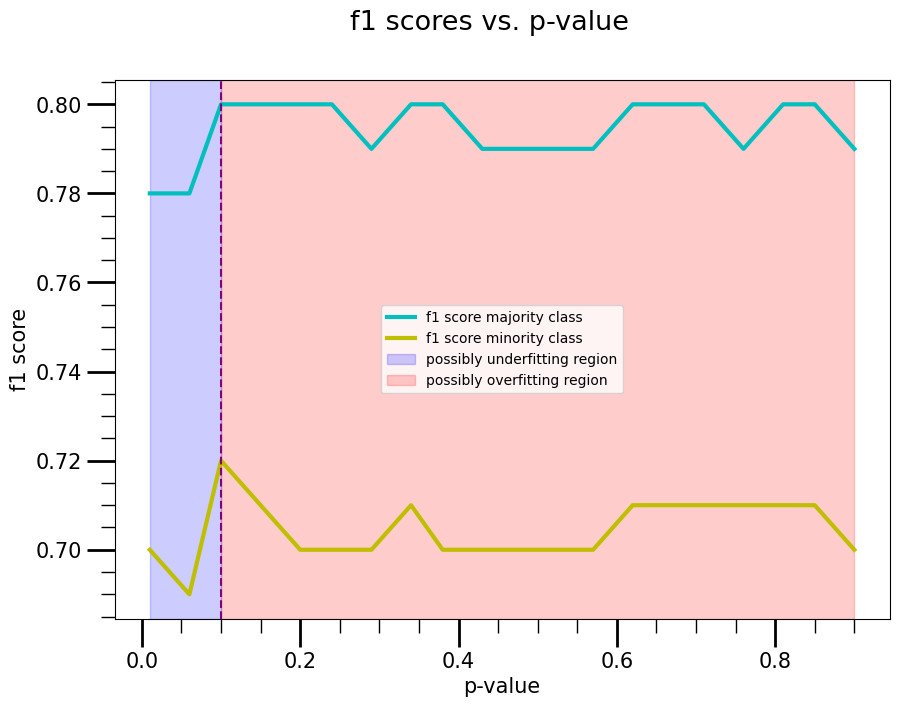

In [6]:
# START of settings
fs = 15  # fontsize
lw = 3  # linewidth
title = "f1 scores vs. p-value"
label_x = "p-value"
label_y = "f1 score"
fig = plt.figure(figsize=[10, 7])
major_tick_length = 20
major_tick_width = 2
minor_tick_length = 10
minor_tick_width = 1
# END of settings

fig.suptitle(title, fontsize=fs*1.3)
plt.plot(p_value_list, f1_scores_majority, linewidth=lw, color='c', label='f1 score majority class')
plt.plot(p_value_list, f1_scores_minority, linewidth=lw, color='y', label='f1 score minority class')
index_max = np.argmax(f1_scores_minority)
plt.axvline(x=p_value_list[index_max], color='purple', linestyle='--')
plt.axvspan(min(p_value_list), p_value_list[index_max], alpha=0.2, color='blue', label='possibly underfitting region')
plt.axvspan(p_value_list[index_max], max(p_value_list), alpha=0.2, color='red', label='possibly overfitting region')
plt.xlabel(label_x, fontsize=fs)
plt.ylabel(label_y, fontsize=fs)
plt.tick_params("both", length=major_tick_length, width=major_tick_width, which="major", labelsize=fs)
plt.tick_params("both", length=minor_tick_length, width=minor_tick_width, which="minor", labelsize=fs)
plt.minorticks_on()
plt.legend(loc='center')
plt.annotate('better choice?\n(p-value = 0.2)', xy=(0.2, 0.85), xytext=(0.3, 0.855),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

- To complement our analysis could be interesting the ratio of number of features with the total number of datapoints as function of the p value.

$$R_{fd} = \frac{N_f}{N_d}$$
- where:
    - $R_{fd}$: is the features-datapoints ratio
    - $N_f$: is the number of features
    - $N_d$: is the number of features

In [7]:
dataset_size = len(dataset_df)
dataset_size_augmented = 1080 * 2
train_dataset_size = int(dataset_size_augmented * 0.8)
test_dataset_size = int(dataset_size_augmented * 0.2)
features_size = [3426, 3315, 3223, 3086, 2962, 2856, 2748, 2606, 2510, 2360,
                 2189, 1956, 1781, 1590, 1394, 1259, 1053, 807, 536, 88]
ratio_list = [x / train_dataset_size for x in features_size]

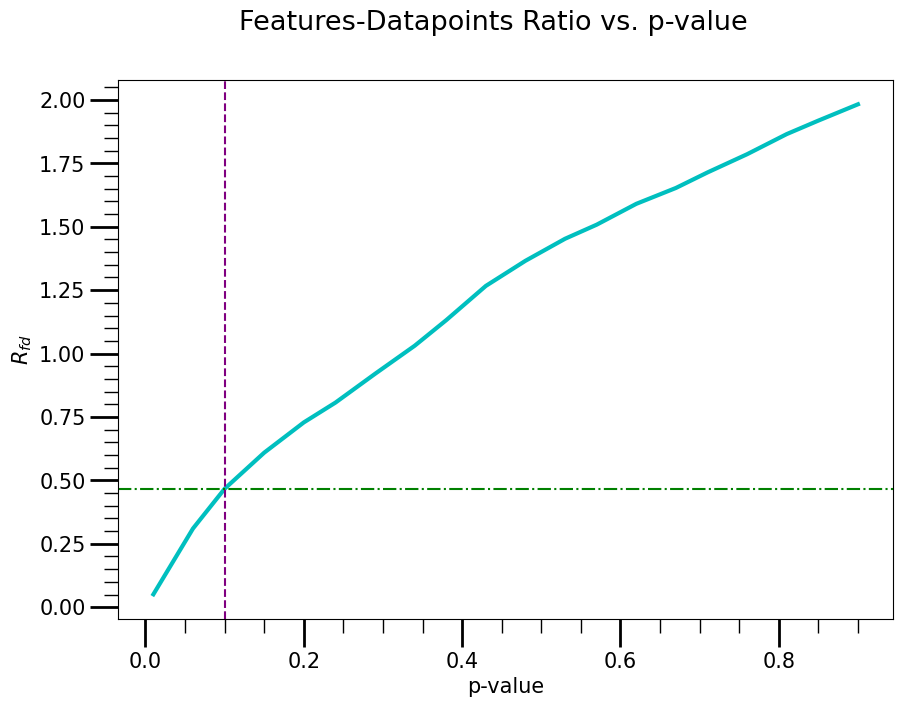

In [8]:
# START of settings
fs = 15  # fontsize
lw = 3  # linewidth
title = "Features-Datapoints Ratio vs. p-value"
label_x = "p-value"
label_y = "$R_{fd}$"
fig = plt.figure(figsize=[10, 7])
major_tick_length = 20
major_tick_width = 2
minor_tick_length = 10
minor_tick_width = 1
# END of settings

fig.suptitle(title, fontsize=fs*1.3)
plt.plot(p_value_list, ratio_list, linewidth=lw, color='c')
index_max = np.argmax(f1_scores_minority)
plt.axvline(x=p_value_list[index_max], color='purple', linestyle='--')
plt.axhline(y=ratio_list[index_max], color='green', linestyle='-.')
plt.xlabel(label_x, fontsize=fs)
plt.ylabel(label_y, fontsize=fs)
plt.tick_params("both", length=major_tick_length, width=major_tick_width, which="major", labelsize=fs)
plt.tick_params("both", length=minor_tick_length, width=minor_tick_width, which="minor", labelsize=fs)
plt.minorticks_on()
plt.show()

In [9]:
p_value_list[index_max]

0.1

## Conclusions
- We conclude that the optimal p-value when using the KNeighborsClassifier with default hyperparameters and data augmentation with minority strategy is $p-value=0.1$.
- The f1-score for the majority class is 0.80 and for the minority class 0.72 when using the default parameters of the RandomForestClassifier of scikit-learn.